In [162]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,10))
import pandas as pd
import scipy

<Figure size 864x720 with 0 Axes>

In [163]:
dff=pd.read_csv('10YRS.csv')

In [164]:
dff.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1992-12-31,6.70,6.70,6.70,6.70,6.70,0.0
1,1993-01-04,6.60,6.60,6.60,6.60,6.60,0.0
2,1993-01-05,6.61,6.61,6.61,6.61,6.61,0.0
3,1993-01-06,6.63,6.63,6.63,6.63,6.63,0.0
4,1993-01-07,6.76,6.76,6.76,6.76,6.76,0.0
5,1993-01-08,6.75,6.75,6.75,6.75,6.75,0.0
6,1993-01-11,6.71,6.71,6.71,6.71,6.71,0.0
7,1993-01-12,6.72,6.72,6.72,6.72,6.72,0.0
8,1993-01-13,6.71,6.71,6.71,6.71,6.71,0.0
9,1993-01-14,6.65,6.65,6.65,6.65,6.65,0.0


In [165]:
df=dff['Adj Close'].dropna()
df=df.tolist()

In [166]:
def SimulateOUkalman (lambda_,Dsig,steps):
    
    '''
    SimulateOUkalman generates mean reverting data as well as a corresponding noisy price observation 
    '''
    #We are directly observing spot price -> H(matrix)=1
    Z=1
    #covariance
    H=0.01
    #noise
    noise_v=np.sqrt(H)*np.random.randn(steps)
    
    #real price from the dataset
    LnS=df
    
    #creating observed data by adding noise to the real dataset
    Obs[0]=Z*LnS[0]+noise_v[0]
    
    for i in range(1,steps):
        Obs[i]=Z*LnS[i]+noise_v[i]

In [167]:
def OUloglikelihoodfn(parameter):
    '''
    OUloglikelihoodfn returns negative of log Maximum Likelihood Estimation of process 
    parameters (mu, lambda, sig, R) fit to observation data with the Kalman filter.
    '''
    
    mu=parameter[0];
    lambda_=parameter[1];
    sig=parameter[2];
    H=parameter[3]; 
    Z=1;
    M=np.exp(-lambda_*TimeDelta);
    
    C=mu*(1-M);
    
    #observation size
    nsamples=len(Obs);
    LikeSum=0.5*nsamples*np.log(2*np.pi);
    x=Z*Obs[0];
    xVec[0]=x;
    if lambda_==0: 
        Q= sig*sig*( (1-exp(-2*lambda_*TimeDelta))/(2*lambda_));
    else:
        Q= sig*sig*(TimeDelta);
    
    P=Z*Q*np.transpose(Z)
        
    for i in range(1,nsamples):
        #x(k|k-1) State Prediction
        x = M*x+C
        
        #P(k|k-1) Covariance Prediction
        P = M*P*np.transpose(M)+ Q
        
        #%Measurement (Innovation
        MR = Obs[i]- Z*x
        
        #Residual (Innovation) Covariance
        F = Z*P*np.transpose(Z) + H;
        #Kalman Gain
        K = P*Z * F**(-1)
        
        #posteriori estimate
        x = x + K*(MR)
        
        #posterior error covariance
        P = P-K*Z*P
        
        #the max. likelihood was multiplied by -1 to give a minimum for fminsearch
        LikeSum=LikeSum +0.5*np.log(F)+0.5*MR*F**(-1)*MR
        xVec[i]=x
    return LikeSum

In [168]:
def OUKalman(): 
    
    '''
    OUKalman gets the bond from SimulateOUkalma then filters a mean reversion process. Underlying parameters
    (mu, lambda, and sigma) of this Ornstein Uhlenbeck process are estimated by the python minimization 
    function fmin
    '''

    global Obs
    global TimeDelta
    global xVec
    global LnS
    #mean reversion rate
    lambda_=1
    #long-term mean
    mu=3
    #Driving Sigma
    Dsig =2
    stepsInput = len(df) 
    TimeLength=5;
    Obs=np.zeros(stepsInput)
    xVec=np.zeros(stepsInput) 
    time = np.linspace(0,TimeLength,stepsInput)  
    TimeDelta= time[1]-time[0]
    
    #Can observed price data (obs)
    SimulateOUkalman (lambda_,Dsig,stepsInput)
    
    
    #Supply initial guess values
    muGuess=9
    lambdaGuess=2
    sigGuess=0.9
    RGuess=0.01
    param=np.zeros((4,1));
    param[0,0]=muGuess;
    param[1,0]=lambdaGuess;
    param[2,0]=sigGuess;
    param[3,0]=RGuess;
    pnew = scipy.optimize.fmin(OUloglikelihoodfn,param )
    muNew = pnew[0]
    lambdaNew = pnew[1];
    DsigNew = pnew[2];
    RNew = pnew[3];
    print( 'Parameters\t\t mu \t lambda \t sigma \n'); 
    print( 'True\t\t\t',round(mu,2),'\t ',' ',round(lambda_,2),'\t\t',round(Dsig,2))
    print('Estimated\t\t',round(muNew,2),'\t ',' ',round(lambdaNew,2),'\t',round(DsigNew,2),'\n')
    print('Measurement Noise Covariance = R =',round(RNew,4));
    fig=plt.figure(figsize=(12,10))
    plt.plot (time,LnS,label='Real Price',linewidth=0.5)
    plt.plot(time, Obs,'--',label='Observed Price',linewidth=0.5)
    plt.plot(time, xVec, '-.',label='Predicted Price')
    plt.xlabel('Time'); 
    plt.ylabel('Price')
    #plt.axis(xmin=0,ymin=0)
    plt.legend()
    plt.savefig('real_1.png')



Optimization terminated successfully.
         Current function value: -3642.981296
         Iterations: 165
         Function evaluations: 287
Parameters		 mu 	 lambda 	 sigma 

True			 3 	    1 		 2
Estimated		 3.26 	    0.86 	 2.04 

Measurement Noise Covariance = R = 0.0104


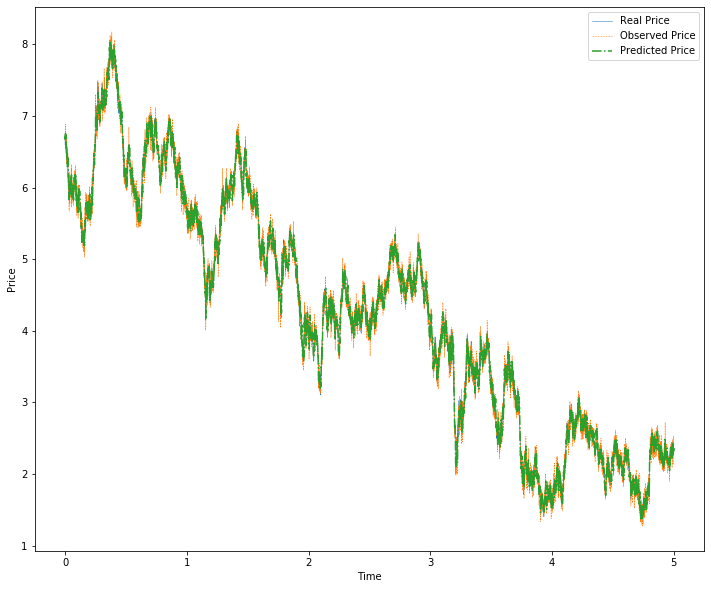

In [169]:
OUKalman()